# **Table of Contents**

- [Introduction](#Introduction)
- [Importing Libraries](#Importing-Libraries)
- [Over Sampling](#Over-Sampling)
- [Pipeline Building](#Pipeline-Building)
- [Modeling](#Modeling)
- [Model Evaluation](#Model-evaluation)
- [Results](#Results)
- [Conclusion](#Conclusion)

## Introduction
### Binary Classification: Day 4 - Class Balancing
- This notebook focuses on Class Balancing techniques like OverSampling to improve model performance.

## Importing Libraries

In [233]:
import sys
sys.path.append("../../")
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
import seaborn as sns
import pandas as pd
import polars as pl
import plotly.express as px
from functions.eda import *
from functions.cat_eda import *
from functions.basic_cleaning import *
from functions.num_eda import *
from functions.pipeline_helpers import *

In [234]:
train_data=pl.read_csv("train_featureEngineered.csv").pipe(reduce_memory_usage)
test_data=pl.read_csv("test_featureEngineered.csv").pipe(reduce_memory_usage)
train_data.head()

customerID,SeniorCitizen,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,MonthlyCharges,TotalCharges,Churn,Streamer,Safer,Family,OnlinePayment,All
str,i8,i8,i8,i8,i8,i8,i8,i8,i8,f32,f32,i8,i8,i8,i8,i8,i8
"""7876-AEHIG""",0,51,0,1,1,0,1,1,12,60.150002,3077.0,0,1,1,1,0,1
"""8752-IMQOS""",0,5,0,2,0,0,0,0,12,20.1,85.099998,0,0,0,1,0,0
"""0256-LTHVJ""",0,28,0,0,0,0,0,0,1,81.050003,2227.100098,1,1,0,1,1,0
"""1981-INRFU""",0,2,0,0,0,0,0,0,1,79.75,164.5,1,1,0,0,1,0
"""0730-KOAVE""",0,30,1,0,1,1,0,0,1,94.300003,2679.699951,0,1,1,0,0,0


In [235]:
cat_cols=["SeniorCitizen","MultipleLines","InternetService","OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","Contract","Streamer","Safer","Family","OnlinePayment","All"]
num_cols=train_data.drop(["Churn","customerID"]+cat_cols)
X_train=train_data.drop("customerID","Churn").to_pandas()
y_train=train_data["Churn"].to_pandas()
X_test=test_data.drop("customerID","Churn").to_pandas()
y_test=test_data["Churn"].to_pandas()

## OverSampling

- Using Smote Nominal and Continuous [Learn More](https://towardsdatascience.com/class-imbalance-from-smote-to-smote-n-759d364d535b)

In [236]:
from imblearn.over_sampling import SMOTEN
sm=SMOTEN(random_state=42,n_jobs=-1)
X_train_smote,y_train_smote=sm.fit_resample(X_train,y_train)
X_test_smote,y_test_smote=sm.fit_resample(X_test,y_test)

In [237]:
balanced_train=pl.from_pandas(X_train_smote).hstack(pl.DataFrame(y_train_smote.to_numpy(),schema=["Churn"]))
balanced_test=pl.from_pandas(X_test_smote).hstack(pl.DataFrame(y_test_smote.to_numpy(),schema=["Churn"]))
balanced_train.write_csv("../Day5_Error_Analysis/balanced_train.csv")
balanced_test.write_csv("../Day5_Error_Analysis/balanced_test.csv")
balanced_train.write_csv("../Day6_Ensemble/balanced_train.csv")
balanced_test.write_csv("../Day6_Ensemble/balanced_test.csv")

## Pipeline Building

In [241]:
from sklearn.model_selection import cross_val_predict,RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score,recall_score,matthews_corrcoef
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.feature_selection import SelectKBest

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

param_distributions = {
    'classifier__C': Real(1e-6, 1e+3, prior='log-uniform'),
    'classifier__max_iter': Integer(100, 1000),
    'classifier__penalty': Categorical(['l1', 'l2']),
    'classifier__fit_intercept': Categorical([True, False]),
    'classifier__solver': Categorical(['liblinear', 'saga'])
}

cat_cols=["SeniorCitizen","MultipleLines","InternetService","OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","Contract","Streamer","Safer","Family","OnlinePayment","All"]
num_cols=train_data.drop(["Churn","customerID"]+cat_cols).columns

transformer = ColumnTransformer(transformers=[("num",StandardScaler(),num_cols)]
                                ,remainder='passthrough')

rskf= RepeatedStratifiedKFold(n_repeats=3,n_splits=3,random_state=42)

pipe_smote = Pipeline(
    [
        ("transformer", transformer),
        ('select',SelectKBest(k=10)),
        ("classifier", LogisticRegression(random_state=42)),
    ]
)
pipe_smote

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges'])])),
                ('select', SelectKBest()),
                ('classifier', LogisticRegression(random_state=42))])

## Modeling

In [242]:
search = BayesSearchCV(
    estimator=pipe_smote,cv=rskf,
    search_spaces=param_distributions,
    n_iter=50,random_state=42,scoring='roc_auc')  

search.fit(X_train_smote, y_train_smote)
best_params = search.best_params_


pipe_smote.set_params(**best_params)
pipe_smote.fit(X_train_smote, y_train_smote)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges'])])),
                ('select', SelectKBest()),
                ('classifier',
                 LogisticRegression(C=0.11566740451422432, max_iter=1000,
                                    penalty='l1', random_state=42,
                                    solver='saga'))])

## Model Evaluation

Mean Train roc auc Score: 0.8650403158861341
Mean Train recall Score: 0.8014545454545456

Mean Test roc auc Score: 0.8640573590449955
Mean Test recall Score: 0.7996767676767677
Recall score: 0.85
Correlation : 0.6298473679858559
Classification Report 
               precision    recall  f1-score   support

           0       0.84      0.78      0.81      1031
           1       0.80      0.85      0.82      1031

    accuracy                           0.81      2062
   macro avg       0.82      0.81      0.81      2062
weighted avg       0.82      0.81      0.81      2062



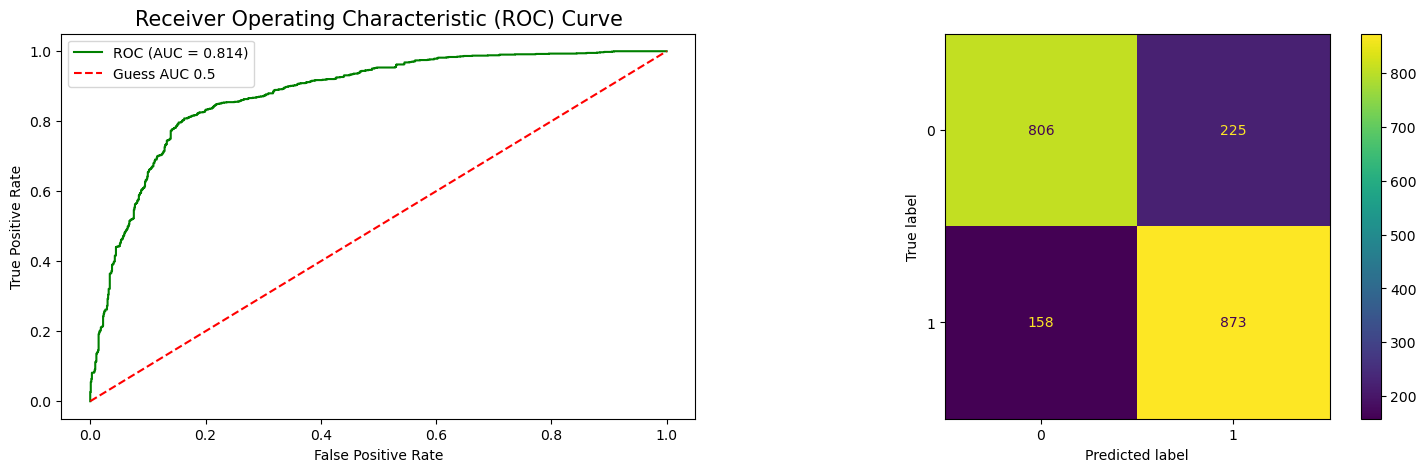

In [243]:
# Evaluation
cv_results = cross_validate(pipe_smote, X_train_smote,y_train_smote, cv=rskf, scoring=['recall','roc_auc'],n_jobs=-1,return_train_score=True,error_score="raise")
from sklearn.model_selection import cross_validate,RepeatedStratifiedKFold
rskf = RepeatedStratifiedKFold(n_splits=3,n_repeats=3,random_state=42)

cv_results = cross_validate(pipe_smote, X_train_smote,y_train_smote, cv=rskf, scoring=['recall','roc_auc'],n_jobs=-1,return_train_score=True,error_score="raise")
print(f'Mean Train roc auc Score: {cv_results["train_roc_auc"].mean()}')
print(f'Mean Train recall Score: \033[1m{cv_results["train_recall"].mean()}\033[0m\n')

print(f'Mean Test roc auc Score: {cv_results["test_roc_auc"].mean()}')
print(f'Mean Test recall Score: \033[1m{cv_results["test_recall"].mean()}\033[0m')
from sklearn.metrics import classification_report,roc_curve,roc_auc_score,recall_score
from sklearn.model_selection import cross_val_predict
# Evaluation
predictions_prob= cross_val_predict(pipe_smote,X_test_smote,y_test_smote,method='predict_proba',n_jobs=-1)
predictions=[0 if x < 0.5 else 1 for x in predictions_prob[:,1]]
roc_auc = roc_auc_score(y_test_smote, predictions)
recall = recall_score(y_test_smote,predictions)
coef = matthews_corrcoef(y_test_smote,predictions)
print(f"\033[1mRecall score: {recall:.2f}\033[0m")
print(f"Correlation : {coef}")
print("\033[4mClassification Report\033[0m \n",classification_report(y_test_smote,predictions))
fpr, tpr, thresholds=roc_curve(y_test_smote,predictions_prob[:,1])
plot_evaluation(fpr, tpr,y_test_smote,predictions,roc_auc)

In [244]:
pipe_smote

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges'])])),
                ('select', SelectKBest()),
                ('classifier',
                 LogisticRegression(C=0.11566740451422432, max_iter=1000,
                                    penalty='l1', random_state=42,
                                    solver='saga'))])

In [245]:
import joblib

joblib.dump(pipe_smote, '../Day5_Error_Analysis/pipe_smote.joblib')

['../Day6_Ensemble/pipe_smote.joblib']

## Results
### Model Performance Summary (Day 4 - SMOTE Oversampling for Churn Prediction)

#### Cross-Validation Results

* **Mean Train ROC AUC Score**: 0.8650
* **Mean Train Recall Score**: 0.8015

* **Mean Test ROC AUC Score**: 0.8641
* **Mean Test Recall Score**: 0.7997

#### Holdout Set Performance

* **Recall Score on Holdout Set**: 0.85

#### Correlation

* **Correlation**: 0.6298

#### Classification Report on Holdout Set

|               | Precision | Recall | F1-Score | Support |
|---------------|-----------|--------|----------|---------|
| **Class 0**   | 0.84      | 0.78   | 0.81     | 1031    |
| **Class 1**   | 0.80      | 0.85   | 0.82     | 1031    |
| **Accuracy**  |           | 0.81   |          | 2062    |
| **Macro Avg** | 0.82      | 0.81   | 0.81     | 2062    |
| **Weighted Avg** | 0.82   | 0.81   | 0.81     | 2062    |

#### Insights

* **Significant Recall Improvement**: After performing SMOTE oversampling, the recall score on the holdout set has significantly improved to 0.85. This indicates that the model is now even more effective at identifying churn cases, which is crucial for churn prediction tasks.

* **Consistency**: The ROC AUC scores for both train (0.8650) and test (0.8641) sets show a consistent and high level of performance, indicating good generalization ability. The recall scores for both train (0.8015) and test (0.7997) sets are also very close, reinforcing the model's reliability.

* **Precision vs. Recall Balance**: The precision for class 1 (churn) has improved to 0.80, while the recall has increased to 0.85. This balance between precision and recall is crucial, as it indicates the model is now more accurate in identifying true churn cases while minimizing false positives.

* **Overall Accuracy**: The overall accuracy has increased to 0.81, reflecting the model's improved performance in distinguishing between churn and non-churn cases after addressing the class imbalance.

* **Correlation**: The correlation between predicted probabilities and actual class labels has significantly improved to 0.6298, indicating a strong relationship and more reliable predictions.

* **Balanced Class Performance**: The classification report shows balanced performance between class 0 and class 1, with both classes having similar precision, recall, and F1-scores. This balance is a positive outcome of the oversampling technique.

#### Improvements from Previous Days

* **Enhanced Recall and Precision**: Compared to Day 3, where the recall was 0.83 and precision for class 1 was 0.53, the current results show substantial improvement with recall at 0.85 and precision at 0.80. This improvement demonstrates the effectiveness of SMOTE oversampling in addressing class imbalance and enhancing model performance.
* **Increased ROC AUC**: The ROC AUC scores have also improved from 0.8419 (Day 3) to 0.8650, indicating better overall model performance.
* **Stronger Correlation**: The correlation has increased from 0.5014 to 0.6298, showing that the model's predictions are more strongly aligned with the actual class labels.

## Conclusion
- 85% of churners are identified with 80% precision (chance that our predicted churners are actually churners). Indicating most of our predicted churners are actual Churners